# Prediction of bioactivity from chemical structure
## Target: 5-HT2a  receptor

In [3]:
!pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.7 MB 1.5 MB/s 


In [4]:
!pip install molvs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 488 kB/s 
  Created wheel for molvs: filename=MolVS-0.1.1-py3-none-any.whl size=32387 sha256=2ec170fd97b6c362ae7f74d27e0722fd6ff478122b372a83817502562698e216
  Stored in directory: /root/.cache/pip/wheels/c4/c2/92/e85190307603c2b3733d43e357abae2d1c66b609bfbba6200d
Successfully built molvs


In [5]:
!pip install pycm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66 kB 2.8 MB/s 
     |████████████████████████████████| 590 kB 10.1 MB/s 


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.model_selection import cross_val_score


In [118]:
from sklearn._config import set_config
set_config(print_changed_only=False)

In [9]:
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import IPythonConsole
from  rdkit.Chem.Scaffolds import MurckoScaffold

In [10]:
# Show Atom Numbers
IPythonConsole.drawOptions.addAtomIndices = True

# Change size for ROMol image
# IPythonConsole.molSize = 350,350

In [11]:
# Support for RDKit-ROMol in Pandas
from rdkit.Chem import PandasTools


In [12]:
from pycm import ConfusionMatrix

In [13]:
# Loading dataset (ChEMBL Bioactivity database, "Target Name" == SEROTONIN)
df_chembl = pd.read_csv('Input/ChEMBL_5HT2A.csv', sep=';')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Exploring dataset

In [14]:
df_chembl

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL558551,NaN,0,258.23,0,0.09,(+)-THALIDOMIDE,O=C1CC[C@@H](N2C(=O)c3ccccc3C2=O)C(=O)N1,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909211,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,B,BAO_0000249,cell membrane format,None,None,None,CHO-K1,Membrane,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307512,NaN
1,CHEMBL104,CLOTRIMAZOLE,4,344.85,1,5.38,CLOTRIMAZOLE,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,Ki,'=',3183.0,nM,5.50,NaN,NaN,UO_0000065,15.94,0.30,0.12,30.85,False,CHEMBL1909211,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,B,BAO_0000249,cell membrane format,None,None,None,CHO-K1,Membrane,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307512,NaN
2,CHEMBL4742201,NaN,0,323.40,0,2.49,11,CN(C)CCN1C(=O)c2ccccc2N(C)C(=O)c2ccccc21,Ki,'>',100000.0,nM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,CHEMBL4669825,Binding affinity to 5HT2A receptor (unknown or...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4665756,1,Scientific Literature,Bioorg Med Chem Lett,2020.0,None,NaN
3,CHEMBL411,DIETHYLSTILBESTROL,4,268.36,0,4.83,DIETHYLSTILBESTROL,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,Ki,'=',1369.0,nM,5.86,NaN,NaN,UO_0000065,21.85,0.40,1.03,14.49,False,CHEMBL1909211,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,B,BAO_0000249,cell membrane format,None,None,None,CHO-K1,Membrane,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307512,NaN
4,CHEMBL54126,NEOSTIGMINE BROMIDE,4,303.20,0,1.94,NEOSTIGMINE BROMIDE,CN(C)C(=O)Oc1cccc([N+](C)(C)C)c1.[Br-],IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909211,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,B,BAO_0000249,cell membrane format,None,None,None,CHO-K1,Membrane,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307512,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19328,CHEMBL683,CLOFIBRIC ACID,0,214.65,0,2.58,2,CC(C)(Oc1ccc(Cl)cc1)C(=O)O,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909211,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,B,BAO_0000249,cell membrane format,None,None,None,CHO-K1,Membrane,NaN,NaN,NaN,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307512,NaN
19329,CHEMBL275854,NaN,0,190.25,0,1.76,29,CC(N)Cc1c[nH]c2ccc(O)cc12,Ki,'=',1.0,nM,9.00,NaN,NaN,UO_0000065,47.31,0.88,7.24,14.51,False,CHEMBL617920,In vitro inhibitory constant against [125I]DOI...,B,BAO_0000221,tissue-based format,Rattus norvegicus,CHEMBL3559724,Cerebral cortex,None,None,NaN,NaN,NaN,CHEMBL322,Serotonin 2a (5-HT2a) receptor,Rattus norvegicus,SINGLE PROTEIN,CHEMBL1145094,1,Scientific Literature,J. Med. Chem.,2

In [15]:
df_chembl.describe(include='all')

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
count,19333,3429,19333.00,19333,19333,19333,19333,19260,19333,16112,1.65e+04,15215,10793.00,161,4031,14271,9385.00,9385,9385,9385,19333,19333,19333,19333,19333,19333,19333,19333,19333,19333,19333,240,6,6,19333,19333,19333,19333,19333,19333.00,19333,16387,17353.00,19333,580
unique,12227,1265,NaN,5696,6,847,4666,12186,64,6,NaN,11,NaN,4,763,5,NaN,85,852,3149,2,1975,1713,4,9,9,11,25,25,31,7,15,1,1,17,9,7,4,1134,NaN,6,17,NaN,16,21
top,CHEMBL42,CLOZAPINE,NaN,326.83,0,None,9,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,Ki,'=',NaN,nM,NaN,Outside typical range,Not Active (inhibition < 50% @ 10 uM and thus ...,UO_0000065,NaN,0.33,None,None,False,CHEMBL1909211,DRUGMATRIX: Serotonin (5-Hydroxytryptamine) 5-...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,None,None,Parental cells: HEKT | PMID: 16412547/ 2935410...,P28223,F340L,CHEMBL224,Serotonin 2a (5-HT2a) receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,NaN,Scientific Literature,J. Med. Chem.,NaN,None,TIME = 1.0 hr
freq,118,118,NaN,140,16104,202,250,118,9395,14094,NaN,12850,NaN,109,1552,12405,NaN,424,55,56,18754,1742,1742,15736,6654,6654,8435,17238,17206,11856,17063,159,6,6,10983,15098,12192,15129,1742,NaN,16387,7533,NaN,13273,222
mean,NaN,NaN,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.56e+09,NaN,7.12,NaN,NaN,NaN,20.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.31,NaN,NaN,2006.51,NaN,NaN
std,NaN,NaN,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.17e+11,NaN,1.17,NaN,NaN,NaN,6.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.35,NaN,NaN,9.67,NaN,NaN
min,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.70e+01,NaN,4.00,NaN,NaN,NaN,5.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,1977.00,NaN,NaN
25%,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00e+01,NaN,6.24,NaN,NaN,NaN,15.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,1999.00,NaN,NaN
50%,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.50e+01,NaN,7.05,NaN,NaN,NaN,18.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,2008.00,NaN,NaN
75%,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.00e+02,NaN,7.96,NaN,NaN,NaN,23.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,2014.00,NaN,NaN


In [16]:
df_chembl.dtypes

Molecule ChEMBL ID             object
Molecule Name                  object
Molecule Max Phase              int64
Molecular Weight               object
#RO5 Violations                object
AlogP                          object
Compound Key                   object
Smiles                         object
Standard Type                  object
Standard Relation              object
Standard Value                float64
Standard Units                 object
pChEMBL Value                 float64
Data Validity Comment          object
Comment                        object
Uo Units                       object
Ligand Efficiency BEI         float64
Ligand Efficiency LE           object
Ligand Efficiency LLE          object
Ligand Efficiency SEI          object
Potential Duplicate              bool
Assay ChEMBL ID                object
Assay Description              object
Assay Type                     object
BAO Format ID                  object
BAO Label                      object
Assay Organi

In [17]:
df_chembl.isnull().sum()

Molecule ChEMBL ID                0
Molecule Name                 15904
Molecule Max Phase                0
Molecular Weight                  0
#RO5 Violations                   0
AlogP                             0
Compound Key                      0
Smiles                           73
Standard Type                     0
Standard Relation              3221
Standard Value                 2790
Standard Units                 4118
pChEMBL Value                  8540
Data Validity Comment         19172
Comment                       15302
Uo Units                       5062
Ligand Efficiency BEI          9948
Ligand Efficiency LE           9948
Ligand Efficiency LLE          9948
Ligand Efficiency SEI          9948
Potential Duplicate               0
Assay ChEMBL ID                   0
Assay Description                 0
Assay Type                        0
BAO Format ID                     0
BAO Label                         0
Assay Organism                    0
Assay Tissue ChEMBL ID      

In [18]:
df_chembl['Standard Type'].value_counts().head(20)

Ki                    9395
IC50                  3733
EC50                  1340
Inhibition            1243
Activity               740
Emax                   449
Ratio                  396
Kd                     248
Selectivity            239
Ratio Ki               182
ED50                   174
Selectivity ratio      150
Intrinsic activity     124
-Log KB                100
Efficacy                85
Ratio EC50              63
pKB                     60
Ke                      60
p[A50]                  46
log(ratio)              44
Name: Standard Type, dtype: int64

## Selection of meaningful columns and rows

In [19]:
df = df_chembl[['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Value', 'Standard Units']]

In [20]:
df = df[df['Standard Units'].str.contains('nM', na=False)]

In [21]:
df.isnull().sum()

Molecule ChEMBL ID      0
Smiles                  9
Standard Type           0
Standard Value        122
Standard Units          0
dtype: int64

In [22]:
df.dropna(inplace=True)

In [23]:
# there are many different activity values for the same molecule
df['Molecule ChEMBL ID'].value_counts()

CHEMBL42         103
CHEMBL39          75
CHEMBL54          72
CHEMBL51          69
CHEMBL85          48
                ... 
CHEMBL53939        1
CHEMBL4465414      1
CHEMBL543613       1
CHEMBL313694       1
CHEMBL141209       1
Name: Molecule ChEMBL ID, Length: 9645, dtype: int64

In [24]:
# bias in activity, on example of most tested mocelule CHEMBL42
df[df['Molecule ChEMBL ID'].str.fullmatch('CHEMBL42')].describe()

,Standard Value
count,103.00
mean,15.20
std,24.99
min,0.69
25%,5.72
50%,9.40
75%,14.25
max,230.00


In [25]:
# handling bias in activity data from different assays: 
# calculationg average activity (mean_value)

df['mean_value'] = df.groupby('Molecule ChEMBL ID')['Standard Value'].transform('mean')

In [26]:
df.head()

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value,Standard Units,mean_value
1,CHEMBL104,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,Ki,3183.0,nM,7162.5
2,CHEMBL4742201,CN(C)CCN1C(=O)c2ccccc2N(C)C(=O)c2ccccc21,Ki,100000.0,nM,100000.0
3,CHEMBL411,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,Ki,1369.0,nM,3079.5
6,CHEMBL900,Cc1ccccc1C(OCCN(C)C)c1ccccc1,IC50,436.0,nM,280.5
11,CHEMBL55,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,IC50,1639.0,nM,1053.5


In [27]:
# well-studied substances (tested for activity in more than 10 assays)

df.groupby('Molecule ChEMBL ID').filter(lambda x: len(x) > 10)

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Value,Standard Units,mean_value
37,CHEMBL39,NCCc1c[nH]c2ccc(O)cc12,EC50,2.34,nM,959.24
63,CHEMBL42,CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1,Ki,4.84,nM,15.20
64,CHEMBL715,Cc1cc2c(s1)Nc1ccccc1N=C2N1CCN(C)CC1,Ki,2.50,nM,10.81
65,CHEMBL6607,COc1cc(CC(C)N)c(OC)cc1Br,Ki,22.00,nM,31.49
99,CHEMBL54,O=C(CCCN1CCC(O)(c2ccc(Cl)cc2)CC1)c1ccc(F)cc1,Ki,27.00,nM,89.61
...,...,...,...,...,...,...
19318,CHEMBL54,O=C(CCCN1CCC(O)(c2ccc(Cl)cc2)CC1)c1ccc(F)cc1,Ki,108.00,nM,89.61
19319,CHEMBL54,O=C(CCCN1CCC(O)(c2ccc(Cl)cc2)CC1)c1ccc(F)cc1,IC50,129.00,nM,89.61
19320,CHEMBL56,CCCN(CCC)C1CCc2cccc(O)c2C1,IC50,10000.00,nM,7119.06
19322,CHEMBL54,O=C(CCCN1CCC(O)(c2ccc(Cl)cc2)CC1)c1ccc(F)cc1,Ki,164.00,nM,89.61


In [28]:
# Drop unnecessary columns and duplicated values to produce dataset 
# with chemical structures and one activity value (e.g. mean from several assays) per substanse

df.drop(['Standard Type', 'Standard Value', 'Standard Units'], axis=1, inplace=True)
df.drop_duplicates('Smiles', keep='first', inplace=True)
df = df.reset_index(drop=True)

In [29]:
# Add ROMol column to dataframe

PandasTools.AddMoleculeColumnToFrame(df,'Smiles','ROMol',includeFingerprints=False)
PandasTools.RenderImagesInAllDataFrames(images=True)

,Molecule ChEMBL ID,Smiles,mean_value,ROMol
0,CHEMBL104,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,7162.5,
1,CHEMBL4742201,CN(C)CCN1C(=O)c2ccccc2N(C)C(=O)c2ccccc21,100000.0,
2,CHEMBL411,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,3079.5,
3,CHEMBL900,Cc1ccccc1C(OCCN(C)C)c1ccccc1,280.5,
4,CHEMBL55,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,1053.5,

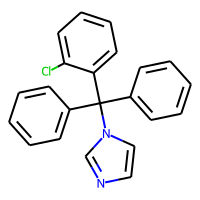
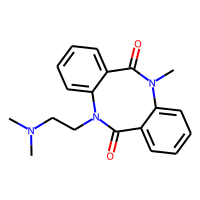
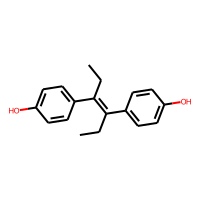
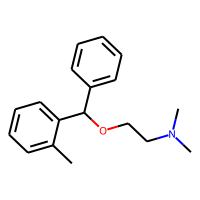
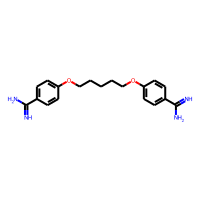

In [30]:
df.head()

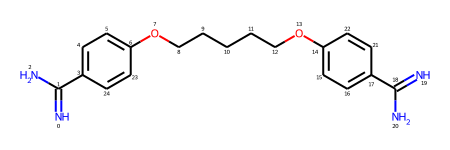

In [31]:
df.ROMol[4]

## Standardization of structures using MolVS 
(based on RDKit.MolStandardize module, see https://molvs.readthedocs.io/en/latest/guide/standardize.html)

In [32]:
from molvs import Standardizer
s = Standardizer()

df['MOL_standardized'] = df['ROMol'].apply(s.standardize)

In [33]:
df['Smiles_standard'] = df['MOL_standardized'].apply(Chem.MolToSmiles)

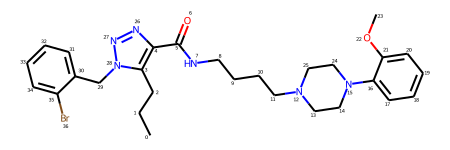

In [34]:
df.MOL_standardized[5678]

In [35]:
df.columns

Index(['Molecule ChEMBL ID', 'Smiles', 'mean_value', 'ROMol',
       'MOL_standardized', 'Smiles_standard'],
      dtype='object')

In [36]:
df.nunique()

Molecule ChEMBL ID    9645
Smiles                9645
mean_value            3963
ROMol                 9645
MOL_standardized      9645
Smiles_standard       9645
dtype: int64

## Data labeling based on activity:


* Class 0: '**weak**'. Active at  > 10000 nM
* Class 1: '**mild**'. Active between 1000 nM and 10000 nM
* Class 2: '**strong**'. Active between 100 nM and 1000 nM
* Class 3: '**very strong**' Active at < 100 nM 


In [ ]:
# conditions_activity = [(df.mean_value <= 100), 
#                       ((df.mean_value > 100) & (df.mean_value <= 1000)), 
#                       ((df.mean_value > 1000) & (df.mean_value <= 10000)), 
#                       (df.mean_value > 10000)]
# labels_activity = ['very strong', 
#                   'strong', 
#                   'mild', 
#                   'weak']
# df['Activity'] = np.select(conditions_activity, labels_activity)

# labels = [3, 2, 1, 0] 
# df['Label'] = np.select(conditions_activity, labels)

In [40]:
df['Label'] = np.where(df.mean_value < 10000, 1, 0)

,Molecule ChEMBL ID,Smiles,mean_value,ROMol,MOL_standardized,Smiles_standard,Label
0,CHEMBL104,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,7162.5,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,1
1,CHEMBL4742201,CN(C)CCN1C(=O)c2ccccc2N(C)C(=O)c2ccccc21,100000.0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",CN(C)CCN1C(=O)c2ccccc2N(C)C(=O)c2ccccc21,0
2,CHEMBL411,CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,3079.5,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",CC/C(=C(/CC)c1ccc(O)cc1)c1ccc(O)cc1,1
3,CHEMBL900,Cc1ccccc1C(OCCN(C)C)c1ccccc1,280.5,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",Cc1ccccc1C(OCCN(C)C)c1ccccc1,1
4,CHEMBL55,N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,1053.5,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",N=C(N)c1ccc(OCCCCCOc2ccc(C(=N)N)cc2)cc1,1
...,...,...,...,...,...,...,...
9640,CHEMBL307717,CN1CCN(C2CC(c3ccc(F)cc3)c3ccc(F)cc32)CC1,7.7,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",CN1CCN(C2CC(c3ccc(F)cc3)c3ccc(F)cc32)CC1,1
9641,CHEMBL428999,Brc1ccc2c3c([nH]c2c1)C=NCC3,1330.0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",Brc1ccc2c3c([nH]c2c1)C=NCC3,1
9642,CHEMBL4759887,CN1CCc2ccc(OCCCCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2C1=O,215.9,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",CN1CCc2ccc(OCCCCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2C1=O,1
9643,CHEMBL494678,CN1CCN(c2cc(-c3ccc(C#N)cc3)nc(N)n2)CC1,4100.0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>","<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",CN1CCN(c2cc(-c3ccc(C#N)cc3)nc(N)n2)CC1,1

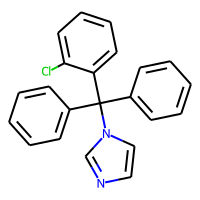
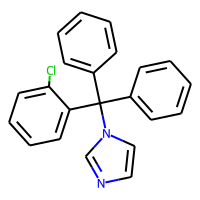
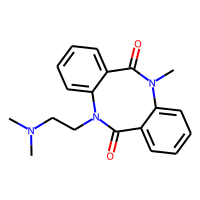
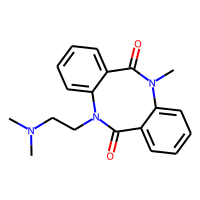
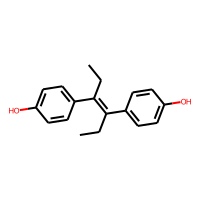
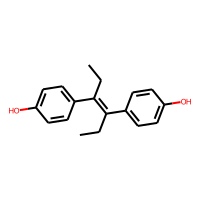
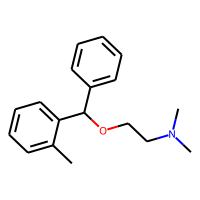
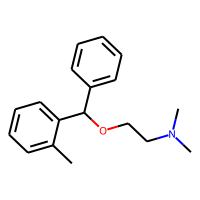
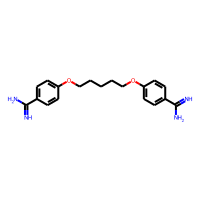
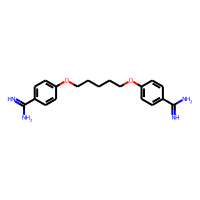
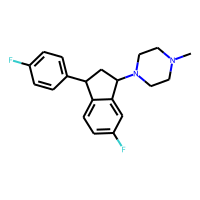
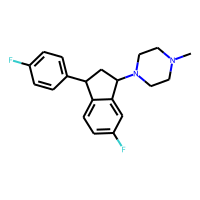
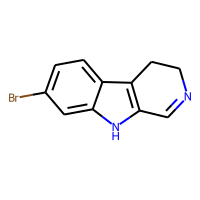
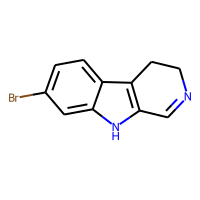
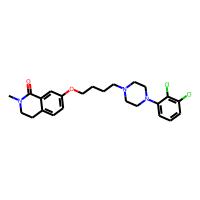
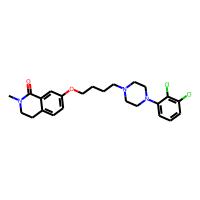
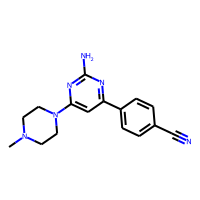
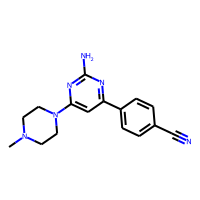
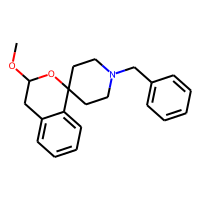
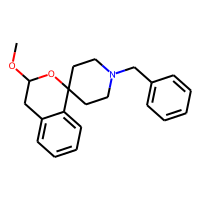

In [43]:
df

In [44]:
df['Name_label']= df['Molecule ChEMBL ID'].astype(str) + '_' + df.Label.astype(str)

In [45]:
df.columns

Index(['Molecule ChEMBL ID', 'Smiles', 'mean_value', 'ROMol',
       'MOL_standardized', 'Smiles_standard', 'Label', 'Name_label'],
      dtype='object')

In [47]:
# Save important columns from datasets as CSV

# df[['Molecule ChEMBL ID', 'Smiles_standard', 'mean_value', 'Activity', 'Label']].to_csv('Output/serotonin_labeled.csv', index=None)
df[['Molecule ChEMBL ID', 'Smiles_standard', 'mean_value', 'Label']].to_csv('Output/serotonin_labeled.csv', index=None)

In [49]:
# Save SMILES structures from datasets for further use

df[['Smiles_standard', 'Name_label']].to_csv('Output/serotonin_labeled.smi', sep='\t', index=None, header=None)

In [53]:
df = df.drop(['Smiles', 'ROMol'], axis = 1)

In [52]:
# df['Activity'].value_counts(normalize=True)

Text(0, 0.5, 'Count')

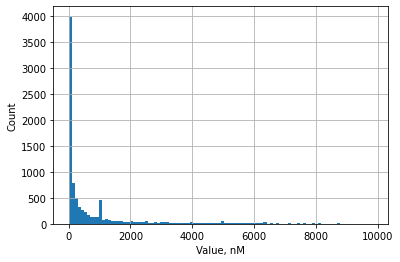

In [54]:
df[df.mean_value < 10000]['mean_value'].hist(bins=100)
plt.xlabel('Value, nM')
plt.ylabel('Count')

## Transformation of molecular structure into bit vector 
### (using Morgan Fingerprints)

In [55]:
def fp_bit(smiles):
    mol = Chem.MolFromSmiles(smiles)
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    return np.array(morgan_fp, dtype=np.int32)

In [56]:
df['Fingerprint'] = df.Smiles_standard.map(fp_bit)

## Dataset split based on Bemis-Murcko Scaffolds

In [57]:
# calculate Bemis-Murcko Scaffolds for all molecules

df['Scaffold'] = df.Smiles_standard.apply(MurckoScaffold.MurckoScaffoldSmiles)

In [58]:
df['Scaffold_ROMol'] = df.Scaffold.apply(Chem.MolFromSmiles)

In [59]:
df.columns

Index(['Molecule ChEMBL ID', 'mean_value', 'MOL_standardized',
       'Smiles_standard', 'Label', 'Name_label', 'Fingerprint', 'Scaffold',
       'Scaffold_ROMol'],
      dtype='object')

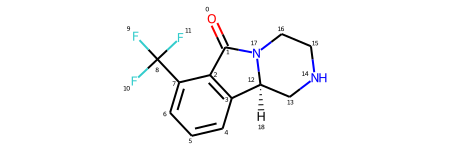

In [60]:
df.MOL_standardized[1115]

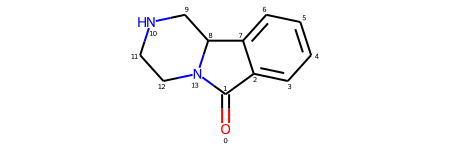

In [61]:
df.Scaffold_ROMol[1115]

In [71]:
# Saving SMILES from datasets for clustering
df[['Scaffold', 'Name_label']].to_csv('Output/serotonin_scaffold.smi', sep='\t', index=None, header=None)

In [76]:
# Clustering molecules with MayaChemTools script (using Butina methodology and Tanimoto similarity metric)

!python "../mayachemtools/bin/RDKitClusterMolecules.py" -i "Output/serotonin_scaffold.smi"\
     -o "Output/serotonin_scaffold_cluster.smi" \
     --infileParams "smilesColumn,1, smilesNameColumn,2, smilesDelimiter,tab, smilesTitleLine,auto, sanitize,yes"\
     --overwrite


RDKitClusterMolecules.py (RDKit v2022.03.2; MayaChemTools v2022.02.12; Sun Jun  5 16:17:56 2022): Starting...

Processing options...

Reading file Output/serotonin_scaffold.smi...
Total number of molecules: 9645
Number of valid molecules: 9644
Number of ignored molecules: 1

Generating Morgan IntVect fingerprints...

Clustering molecules using Butina methodology and Tanimoto similarity metric...
Generating file Output/serotonin_scaffold_cluster.smi...

Total number of clusters: 953

Number of clusters containing only a single molecule: 367
Average number of molecules per cluster: 10.1

Number of molecules in each cluster:
ClusterNumber,MolCount
1,887
2,160
3,82
4,9
5,79
6,167
7,190
8,166
9,100
10,93
11,38
12,46
13,127
14,182
15,20
16,99
17,69
18,98
19,36
20,24
21,21
22,9
23,159
24,3
25,159
26,157
27,64
28,33
29,54
30,144
31,18
32,35
33,5
34,40
35,12
36,1
37,25
38,7
39,118
40,46
41,113
42,14
43,19
44,2
45,43
46,74
47,103
48,101
49,101
50,22
51,56
52,37
53,80
54,16
55,12
56,93
57,1
58,3

In [77]:
scaffold_cluster = pd.read_csv('Output/serotonin_scaffold_cluster.smi', sep= ' ')\
      .rename(columns={'SMILES': 'Scaffold_SMILES', 'Name': 'Name_label', 'ClusterNumber': 'Cluster'})
      
scaffold_cluster.head()

,Scaffold_SMILES,Name_label,Cluster
0,c1ccc(CCCCN2CCN(c3ccccc3)CC2)cc1,CHEMBL3649662_1,1
1,c1ccc(CCN2CCC(Cc3ccccc3)CC2)cc1,CHEMBL490846_1,1
2,O=S(=O)(NCCCN1CCN(c2ccccc2)CC1)c1ccc2ccccc2c1,CHEMBL497749_1,1
3,O=C(NCCN1CCN(c2ccccc2)CC1)c1cn(-c2ccccc2)cn1,CHEMBL3216300_1,1
4,O=C1Nc2ccccc2C1CCCCN1CCN(c2ccccc2)CC1,CHEMBL409662_1,1


In [78]:
scaffold_cluster.shape

(9644, 3)

In [79]:
df.shape

(9645, 11)

In [80]:
scaffold_cluster.Cluster.value_counts()

1      887
7      190
14     182
6      167
8      166
      ... 
164      1
165      1
171      1
174      1
953      1
Name: Cluster, Length: 953, dtype: int64

In [81]:
scaffold_cluster.Cluster.max()

953

In [85]:
# adding cluster number to main dataframe
df = df.merge(scaffold_cluster, on='Name_label', how='left')

In [86]:
df.columns

Index(['Molecule ChEMBL ID', 'mean_value', 'MOL_standardized',
       'Smiles_standard', 'Label', 'Name_label', 'Fingerprint', 'Scaffold',
       'Scaffold_ROMol', 'Scaffold_SMILES', 'Cluster'],
      dtype='object')

In [87]:
df.Cluster.isna().sum()

1

In [88]:
df.Cluster = df.Cluster.fillna(df.Cluster.max()+1)

In [89]:
df.Cluster.isna().sum()

0

In [90]:
df = df.drop('Scaffold_SMILES', axis=1)

In [91]:
THRESHOLD = 10
train_df = df.groupby('Cluster').filter(lambda a: len(a) >= THRESHOLD)
test_df = df.groupby('Cluster').filter(lambda a: len(a) < THRESHOLD)

In [92]:
train_df.shape 

(7798, 10)

In [93]:
test_df.shape

(1847, 10)

In [94]:
X_train = pd.DataFrame(train_df.Fingerprint.to_list())
X_test = pd.DataFrame(test_df.Fingerprint.to_list())
y_train = train_df.Label
y_test = test_df.Label

In [95]:
print('Training set shape: ', X_train.shape, y_train.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (7798, 2048) (7798,)
Testing set shape:  (1847, 2048) (1847,)


## Models training and evaluations

In [119]:
knn = KNeighborsClassifier()
rf = RandomForestClassifier(max_depth=10, n_estimators = 500)
lin_svc = LinearSVC(random_state=42, max_iter=4000)
svc = SVC(gamma='scale', random_state=42)


In [100]:
estimators = {
    'KNeighborsClassifier': knn,
    'Random forest': rf,
    'LinearSVC': lin_svc,
    'SVC': svc}

In [103]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [104]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=500)

In [105]:
lin_svc.fit(X_train, y_train)

LinearSVC(max_iter=4000, random_state=42)

In [106]:
svc.fit(X_train, y_train)

SVC(random_state=42)

KNeighborsClassifier: train score=95.54%; test score=81.16%


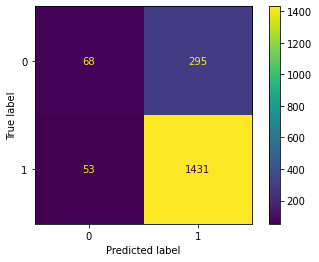




Random forest: train score=93.58%; test score=80.67%


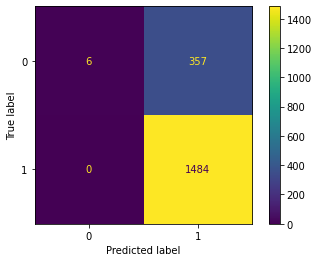




LinearSVC: train score=98.59%; test score=78.45%


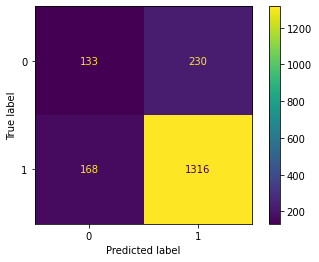




SVC: train score=95.19%; test score=81.43%


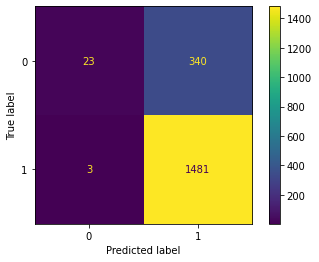

In [108]:
# Evaluation: confusion matrices for dirrefent estimators

for estimator_name, estimator_object in estimators.items():
    print(f'{estimator_name}: ' +
          f'train score={estimator_object.score(X_train, y_train):.2%}; ' +
          f'test score={estimator_object.score(X_test, y_test):.2%}')
   
    metrics.ConfusionMatrixDisplay.from_estimator(estimator_object, X_test, y_test,
                           display_labels=estimator_object.classes_)
    plt.show()
    print()
    print()
    print()

## Hypermarameters tuning


### for K-Neighbors Classifier

In [109]:
knn_params = { 'n_neighbors' : [3,7,11,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [110]:
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, verbose = 1, cv=3, n_jobs = -1)
knn_grid.fit(X_train, y_train)
print('KNN best score: ', knn_grid.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
KNN best score:  0.9426779037302314
KNN best parameters:  {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}


In [113]:
print('KNN best parameters: ', knn_grid.best_params_)

KNN best parameters:  {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}


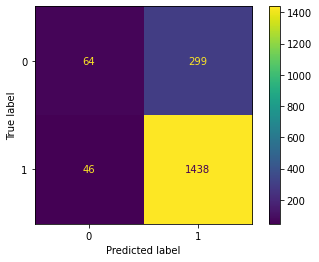

In [134]:
metrics.ConfusionMatrixDisplay.from_estimator(knn_grid, X_test, y_test, display_labels=knn_grid.classes_)

## testing of model on unknown molecules

In [ ]:
# test data input 
input_mol = input('Enter molecular structure in SMILE format:')



Enter molecular structure in SMILE format:NCcccccC


In [ ]:
# draw entered molecule
Chem.MolFromSmiles(input_mol)

In [ ]:
mol_test = Standardizer().standardize(Chem.MolFromSmiles(input_mol))
data_test = np.asarray(fp_bit(mol_test), dtype=int).reshape(1,2048)

ArgumentError: ignored

In [ ]:
data_test

array([[0, 1, 0, ..., 0, 0, 0]])

In [ ]:
for estimator_name, estimator_object in estimators.items():
    class_predicted = estimator_object.predict(data_test).tolist()
    print(f'{estimator_name:>20}: {class_predicted}')

KNeighborsClassifier: [1]
       Random forest: [2]
           LinearSVC: [1]
                 SVC: [1]


In [ ]:
knn.predict_proba(data_test).tolist()

[[0.0, 0.6, 0.4, 0.0]]

In [ ]:
rf.predict_proba(data_test).tolist()

[[0.057011915352953524,
  0.30661207803991514,
  0.34247118914970354,
  0.2939048174574279]]

# SCREENING: predictions for DrugBank Drugs

In [ ]:
db=np.load('drugbank.npy', allow_pickle=True)

In [ ]:
db_f=db[0:,0:2048]

In [ ]:
db_id=db[0:,2048]

In [ ]:
db_predicted = rf.predict(db_f)

In [ ]:
db_df = pd.DataFrame(db.predict, columns='predicted_class')
db_labels = pd.DataFrame(db_id, columns='drug_name')

In [ ]:
db_pred = np.concat([db_df, db_labels], axis = 1)

In [ ]:
db_positive = db_pred.loc[db_pred.predicted_class == 1]